# Homework 4

# Задача №1 - Лего детальки

Имеется 2 выборки из датасета фотографий лего картинок. Структура одной выборки следующая:
```
test
| -- 'target.jpg'
| -- source
|    | -- '*.jpg'
|           ...
|    | -- '*.jpg'
```
В выборке есть опорное изображение - target.jpg и набор из 20 картинок в папке source.

Ваша задача - написать программу, которая прочитает все изображения и определит на каких изображениях из папки source сфотографирована такая же лего деталька, что и деталь в target.jpg

Результатом выполнения программы должен быть файлик с названиями подходящих изображений. Пример в Datasets/gt
Снизу представлены 2 вспомогательные функции: чтение всех изображений из папки и посчет получившихся метрик точности

Результат выполнения данной задачи напрямую зависит от полученных метрик. Полученные метрики будут вычисляться из метрик по двум тестам $Accuracy=min({Accuracy}_{test1}, {Accuracy}_{test2}$)

| Accuracy | Recall | % Выполнения |
|:--------:|:------:|:------------:|
|< 0.6|< 0.4|0%|
|  >= 0.6  | >= 0.4 |     75%      |
|  >= 0.7  | >= 0.5 |     100%     |
|  >= 0.9  | >= 0.8 |     150%     |

<table><tr>
    <td> <img src="Datasets/test1/target.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="Datasets/test2/target.jpg" alt="Drawing" style="width: 400px;"/> </td>

</tr></table>

In [150]:
from pathlib import Path
import os

def read_all_image_paths(folder):
    folder = Path(folder)
    image_paths = [i.__str__() for i in folder.glob('*.jpg')]
    return image_paths

def return_metrics(gt_path, prediction_path):
    with open(gt_path) as f:
        gt = set([i.strip('\n') for i in f.readlines() if len(i)])
    with open(prediction_path) as f:
        pred = set([i.strip('\n') for i in f.readlines() if len(i)])

    len_dataset = 20

    TP, TN, FP, FN = (0, ) * 4
    for i in pred:
        if i in gt:
            TP += 1
            gt.remove(i)
        else:
            FP += 1
    FN = len(gt)
    TN = len_dataset - TP - FP - FN

    accuracy = (TP + TN) / len_dataset
    recall = TP / (TP + FN)

    print(f'Acc: {accuracy:.2f}')
    print(f'Recall: {recall:.2f}')

In [151]:
import cv2
import numpy as np

def WhichImagesShowTheSamePart(target_image, source_images, delta=0.15):
    target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    target_equalized = clahe.apply(target_gray)
    target_median_blur = cv2.medianBlur(target_equalized, 7)
    target_dilate = cv2.dilate(target_median_blur, np.ones((5, 5), np.uint8), iterations=3)
    target_blur = cv2.bilateralFilter(target_dilate, d=9, sigmaColor=40, sigmaSpace=40)
    target_threshold = cv2.adaptiveThreshold(target_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 3)
    target_erode = cv2.dilate(target_threshold, np.ones((3, 3), np.uint8), iterations=3)
    contours, _ = cv2.findContours(target_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    target_countor = max(contours, key=cv2.contourArea)
    result = []
    for i, source_image in enumerate(source_images):
        source_gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
        source_equalized = clahe.apply(source_gray)
        source_median_blur = cv2.medianBlur(source_equalized, 9)
        source_dilate = cv2.dilate(source_median_blur, np.ones((5, 5), np.uint8), iterations=3)
        source_blur = cv2.bilateralFilter(source_dilate, d=9, sigmaColor=45, sigmaSpace=50)
        source_threshold = cv2.adaptiveThreshold(source_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 3)
        source_erode = cv2.dilate(source_threshold, np.ones((3, 3), np.uint8), iterations=3)
        contours, _ = cv2.findContours(source_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        source_countor = max(contours, key=cv2.contourArea)
        
        if cv2.matchShapes(target_countor, source_countor, cv2.CONTOURS_MATCH_I1, 0) < delta:
            result.append(i)

    return result


def GetMetricsForTest(test):
    images_folder = Path(os.path.abspath('')) / 'Datasets' / test / 'source'
    target_path = Path(os.path.abspath('')) / 'Datasets' / test / 'target.jpg'
    output_path = Path(os.path.abspath('')) / (test + '.txt')
    images = []
    paths = []
    for img_path in read_all_image_paths(images_folder):
        paths.append(img_path[-19:]) # Чтобы только название попало
        images.append(cv2.imread(img_path))

    target = cv2.imread(target_path)
    images_index = WhichImagesShowTheSamePart(target, images)
    with open(output_path, "w") as f:
        for index in images_index:
            f.write(paths[index] + '\n')
    
    gt_test1 = Path(os.path.abspath('')) / 'Datasets' / 'gt' / (test + '.txt')
    pred1 = Path(os.path.abspath('')) / (test + '.txt')
    return_metrics(gt_test1, pred1)



print("First dataset:")
GetMetricsForTest('test1')
print("Second dataset:")
GetMetricsForTest('test2')


First dataset:
Acc: 0.95
Recall: 1.00
Second dataset:
Acc: 0.95
Recall: 1.00


# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

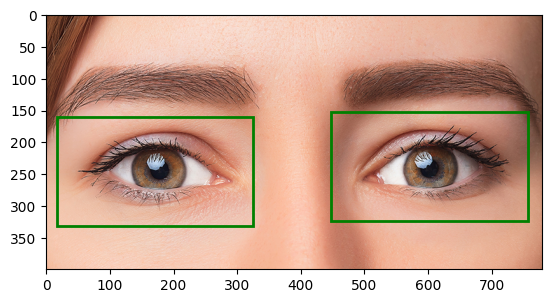

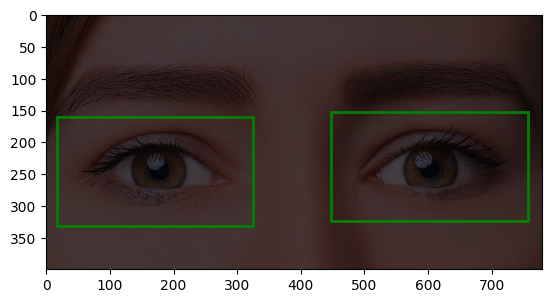

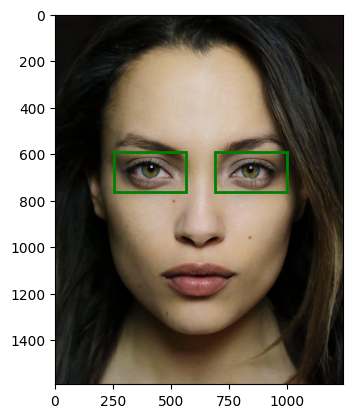

In [ ]:
 # type: ignore
from skimage.feature import hog
import matplotlib.pyplot as plt


def FindEyeOnImage(image, template):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    _, image_hog = hog(image, 8, (8, 8), (2, 2), visualize=True, channel_axis=None)
    _, template_hog = hog(template, 8, (8, 8), (2, 2), visualize=True, channel_axis=None)

    pad_rows, pad_cols = template_hog.shape[0] - 1, template_hog.shape[1] - 1
    padded_image_hog = np.pad(image_hog, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode="constant")
    correlation = cv2.filter2D(padded_image_hog, -1, template_hog)

    _, _, _, max_loc = cv2.minMaxLoc(correlation)
    center = (max_loc[0] - pad_cols, max_loc[1] - pad_rows)

    return center


def DrawRectangles(image, template):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    th, tw = template.shape[:2]

    center = FindEyeOnImage(image, template)
    top_left_1 = (center[0] - tw // 2, center[1] - th // 2)

    image[:, top_left_1[0] : top_left_1[0] + tw] = 0

    center = FindEyeOnImage(image, cv2.flip(template, 1))
    top_left_2 = (center[0] - tw // 2, center[1] - th // 2)
    
    rect1 = plt.Rectangle(top_left_1, tw, th, linewidth=2, edgecolor="g", facecolor="none")
    rect2 = plt.Rectangle(top_left_2, tw, th, linewidth=2, edgecolor="g", facecolor="none")
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.show()



img_path = ["hog/eyes.jpg", "hog/eyes_dark.jpg", "hog/woman.jpg"]
images = []
for path in img_path:
    images.append(cv2.imread(path))

template = cv2.imread("hog/eye.png")
for image in images:
    DrawRectangles(image, template)